# Hotel Reservation Prediction

Develop a supervised machine learning model using the Random Forest algorithm to predict whether
the guest will cancel the reservation or not.

#  Import Libraries

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
import json

!pip install feature-engine
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from yellowbrick.classifier import ConfusionMatrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold


from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

#  Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset URL : https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset/data

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Hactiv8/Hotel_Reservations.csv")
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


Here the explanation about the FEATURE:
* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [7]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [8]:
df.nunique()

Booking_ID                              36275
no_of_adults                                5
no_of_children                              6
no_of_weekend_nights                        8
no_of_week_nights                          18
type_of_meal_plan                           4
required_car_parking_space                  2
room_type_reserved                          7
lead_time                                 352
arrival_year                                2
arrival_month                              12
arrival_date                               31
market_segment_type                         5
repeated_guest                              2
no_of_previous_cancellations                9
no_of_previous_bookings_not_canceled       59
avg_price_per_room                       3930
no_of_special_requests                      6
booking_status                              2
dtype: int64

In [9]:
df.duplicated().sum()

0

# Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Hotel Booking Status')

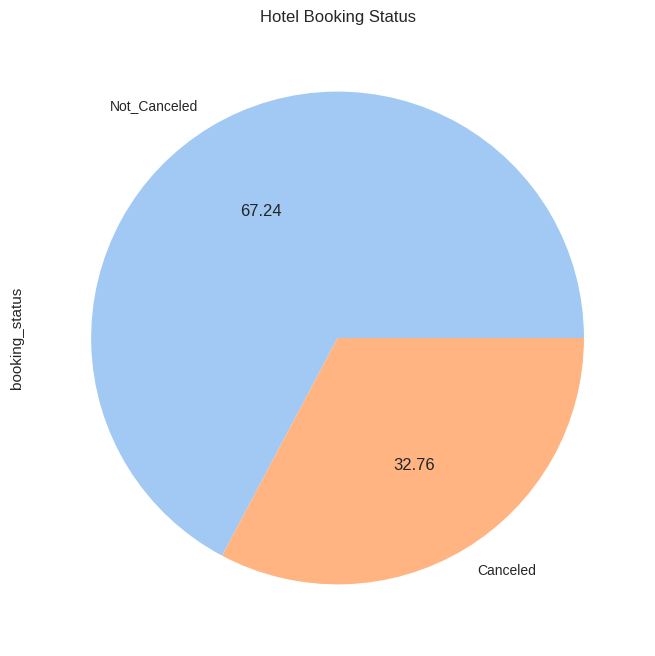

In [10]:
df['booking_status'].value_counts().plot(kind='pie', figsize=(8,8), autopct='%.2f', colors=sns.color_palette('pastel'))
plt.title('Hotel Booking Status')

Insight : The percentage of customers who canceled in the period 2017 to 2018 was around 67%

Text(0.5, 0, 'Room Count Reserved')

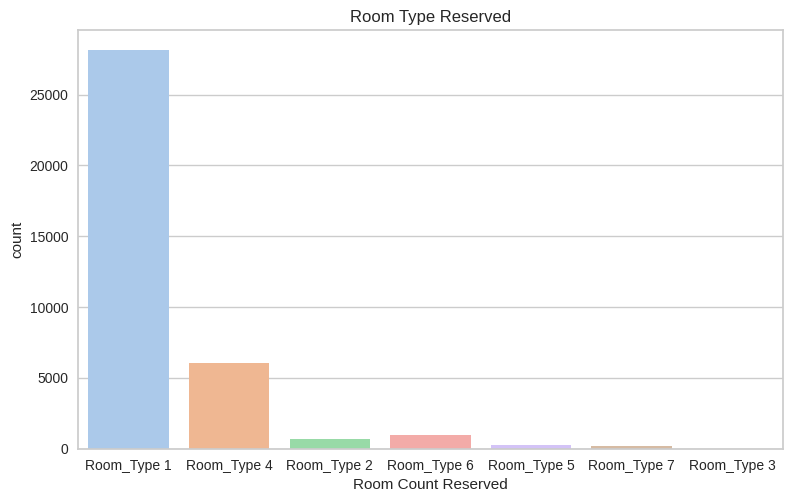

In [11]:
plt.figure(figsize = (20,25))
plt.subplot(4, 2, 2)
plt.gca().set_title('Room Type Reserved')
sns.countplot(x='room_type_reserved', palette='pastel', data=df)
plt.gca().set_xlabel('Room Count Reserved')

Insight : The most reserved rooms are room type 1, follow by room type 4 and type 6.

8475
14739


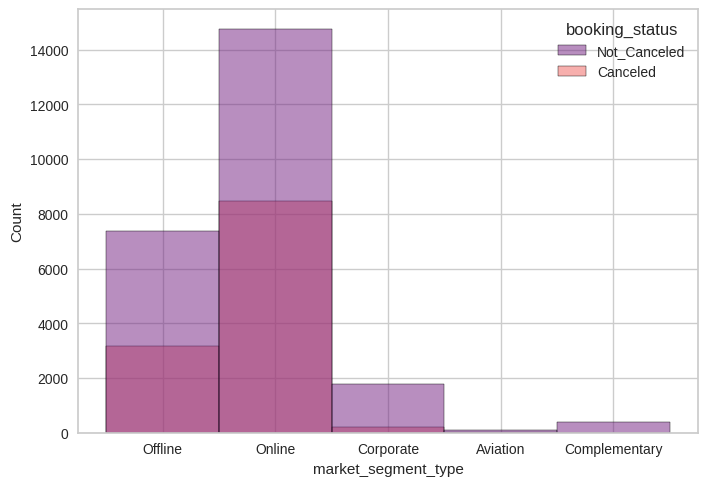

In [12]:
sns.histplot(data = df,x='market_segment_type', hue='booking_status',  palette='magma')

print(df[(df.booking_status == 'Canceled') & (df.market_segment_type == 'Online')].count()[0])
print(df[(df.booking_status == 'Not_Canceled') & (df.market_segment_type == 'Online')].count()[0])

**Insight** :
- Most customers choose to book hotels online compared to offline, but it also appears that more customers are canceling reservations.
- There are not as many corporate bookings but the chances of canceling them are much less.

Text(0.6944444444444517, 0.5, 'Number of bookings')

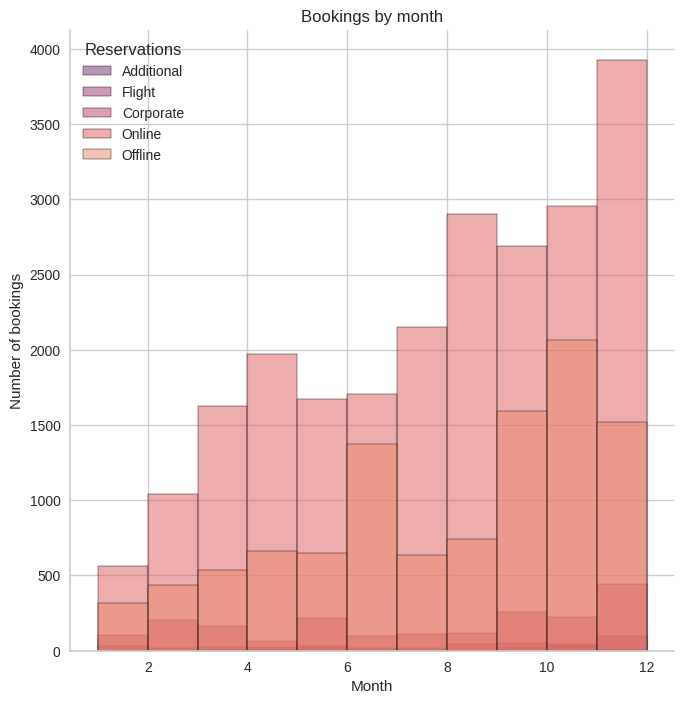

In [13]:
sns.displot(df, x='arrival_month', binwidth=1, height=7, palette='flare', hue='market_segment_type', legend = False)
plt.gca().set_title('Bookings by month')
plt.legend(title= 'Reservations',
           labels=['Additional','Flight','Corporate','Online','Offline'])
plt.xlabel('Month')
plt.ylabel('Number of bookings')

Insight : The number of bookings increases on August to December and mostly customer booking by online.

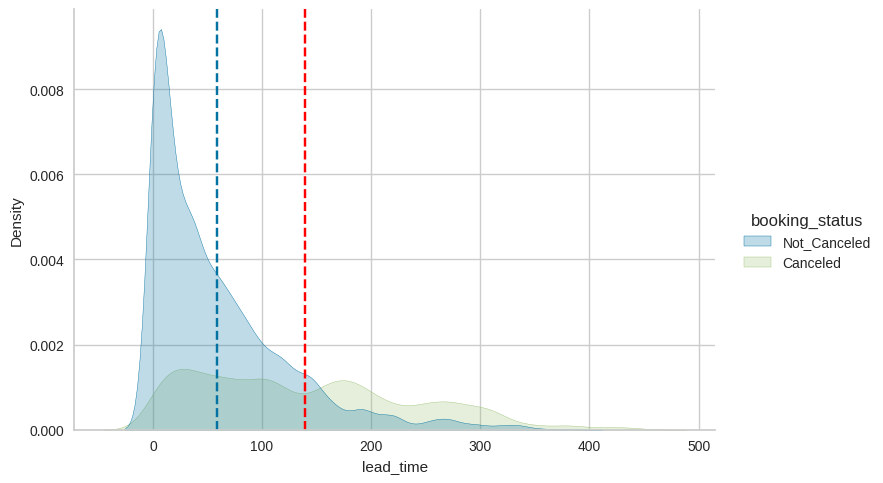

In [14]:
# plot lead time dan booking status
sns.displot(df, x='lead_time', hue='booking_status', kind='kde', fill=True, height=5, aspect=1.5)
plt.axvline(df[df.booking_status == 'Not_Canceled'].lead_time.mean(),ls='--')
plt.axvline(df[df.booking_status == 'Canceled'].lead_time.mean(),ls='--', c='red')

**Insight** : Customers who make bookings on average around > 100 days from the check-in date have a greater possibility of canceling, whereas if customers make bookings for a maximum of 90 days in the future, they tend not to cancel.

# Feature Engineering

##Check missing value

In [16]:
df.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

##Drop feature

In [17]:
#drop unnecessary feature
data = df.drop('Booking_ID', axis=1)
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


##Split Data

In [18]:
#separation of X and y
X = data.drop('booking_status', axis=1)
y = data['booking_status']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

##Split numerical & categorical column

In [20]:
# create categorical and numerical columns

num_columns = X_train.select_dtypes(include='number').columns.tolist()
cat_columns = X_train.select_dtypes(include='object').columns.tolist()


print('Num Columns : ', num_columns)
print('cat Columns : ', cat_columns)

Num Columns :  ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
cat Columns :  ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']


In [21]:
# create categorical and numerical data

X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

X_train_cat = X_train[cat_columns]
X_test_cat = X_test[cat_columns]

In [22]:
# split X train non categorical
X_train_num_nc = X_train_num.loc[:,['lead_time','avg_price_per_room']]
X_test_num_nc = X_test_num.loc[:,['lead_time','avg_price_per_room']]

In [23]:
# ganti nilai y train dan test dengan mapp
target_map = {'Canceled': 0, 'Not_Canceled' : 1}

y_train_map = y_train.map(target_map)
y_test_map = y_test.map(target_map)

y_test_map[0:5]

4968     1
34540    1
36108    1
1553     0
24974    1
Name: booking_status, dtype: int64

##Check outlier

In [24]:
# Create histogram and boxplot for visualize price and skewness value
def diagnostic_plots(nc, variable):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(y=nc[variable])
    plt.title('Skewness of Numerical Columns')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=nc
    [variable])
    plt.title('Outliers')
    plt.show()

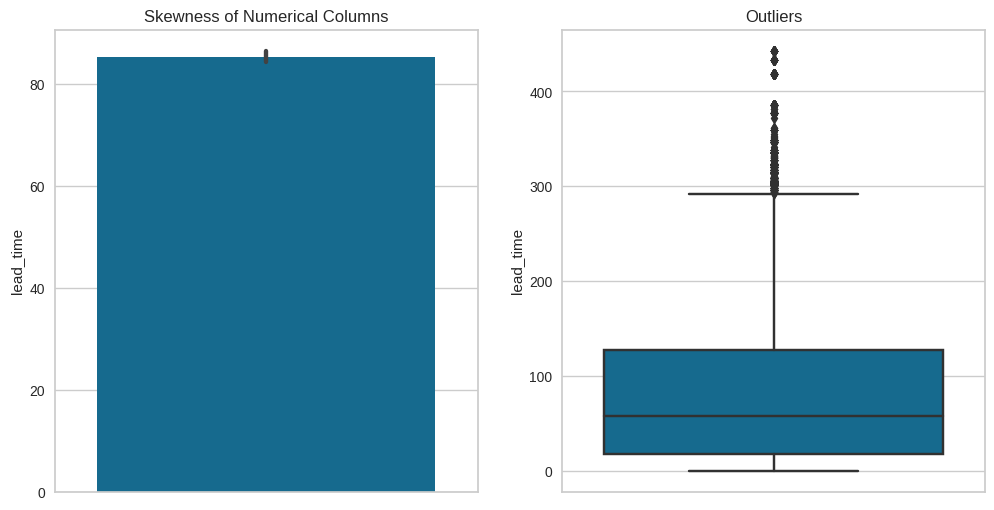


Skewness Value lead_time :  1.289143998432937


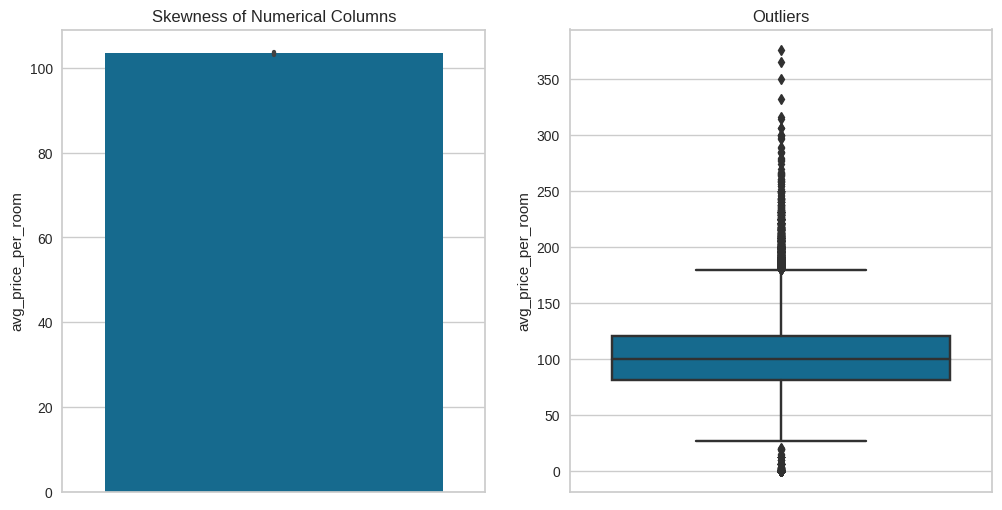


Skewness Value avg_price_per_room :  0.6237719988181157


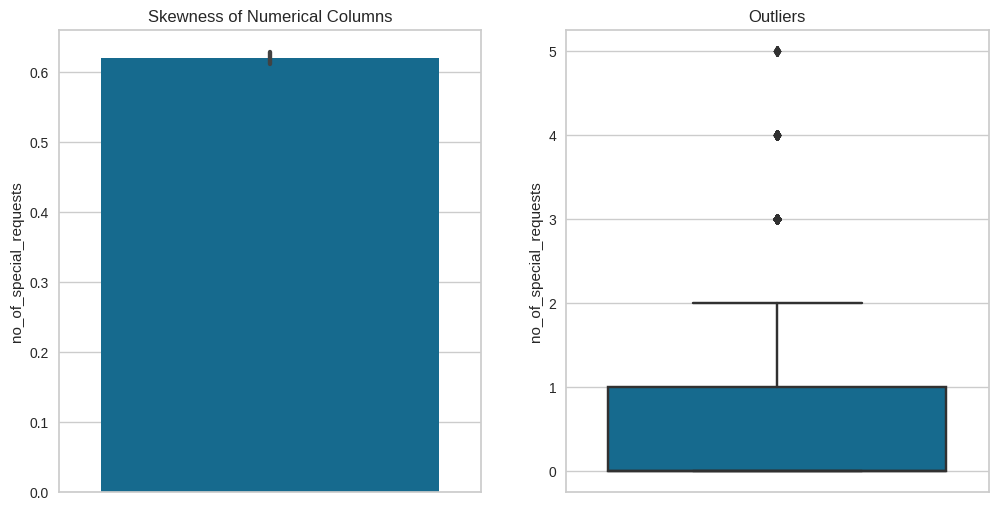


Skewness Value no_of_special_requests :  1.1504482948802144


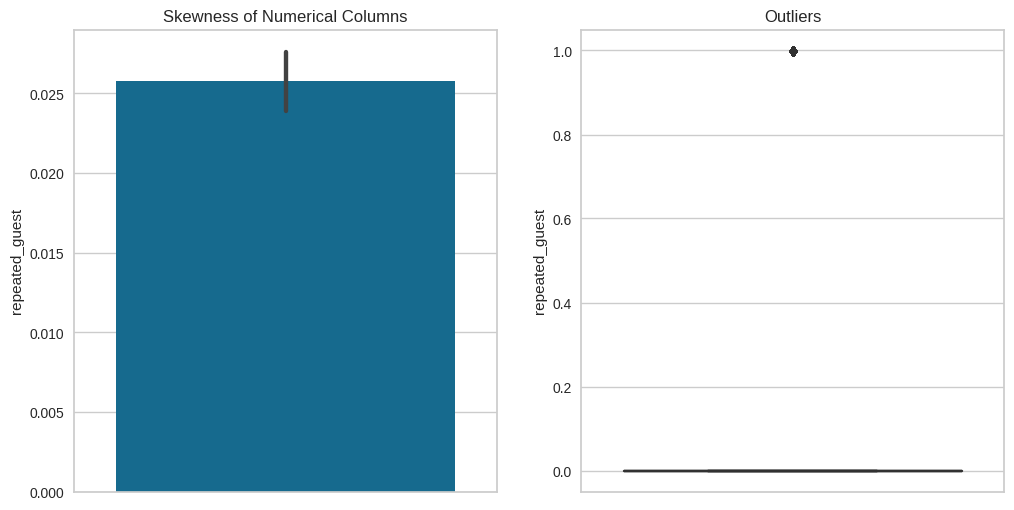


Skewness Value repeated_guest :  5.985561991635112


In [25]:
# Check distribution of features and outliers using Boxplot
diagnostic_plots(X_train_num, 'lead_time')
print('\nSkewness Value lead_time : ', X_train_num['lead_time'].skew())

diagnostic_plots(X_train_num, 'avg_price_per_room')
print('\nSkewness Value avg_price_per_room : ', X_train_num['avg_price_per_room'].skew())

diagnostic_plots(X_train_num, 'no_of_special_requests')
print('\nSkewness Value no_of_special_requests : ', X_train_num['no_of_special_requests'].skew())

diagnostic_plots(X_train_num, 'repeated_guest')
print('\nSkewness Value repeated_guest : ', X_train_num['repeated_guest'].skew())


In [26]:
# Create a Winsorizer object with specified parameters
winsorizer = Winsorizer(capping_method='iqr',
                        tail='both',
                        fold=1.5,
                        variables=['lead_time','avg_price_per_room'])

# Fit the Winsorizer on the training data
winsorizer.fit(X_train_num, X_test_num)

# Transform the training data by applying Winsorizing
X_train_numws = winsorizer.transform(X_train_num)
X_test_numws = winsorizer.transform(X_test_num)

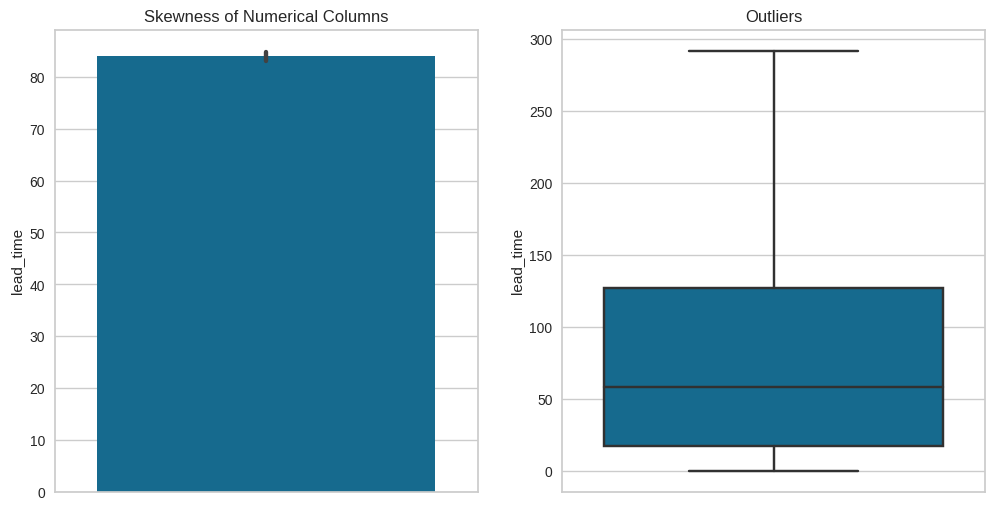


Skewness Value lead_time :  1.0798700716525962


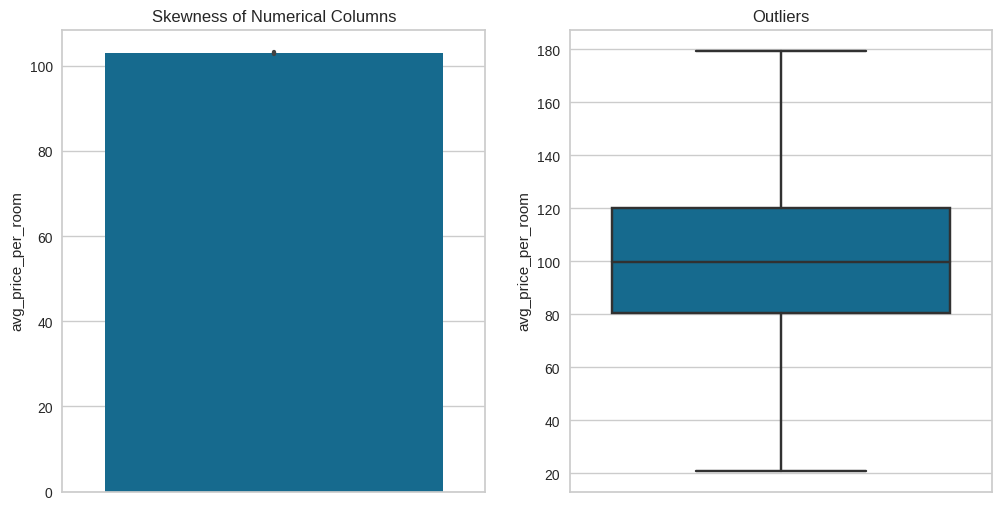


Skewness Value avg_price_per_room :  0.3481757853535358


In [27]:
# Check distribution of features and outliers using Boxplot
diagnostic_plots(X_train_numws, 'lead_time')
print('\nSkewness Value lead_time : ', X_train_numws['lead_time'].skew())

diagnostic_plots(X_train_numws, 'avg_price_per_room')
print('\nSkewness Value avg_price_per_room : ', X_train_numws['avg_price_per_room'].skew())

Insight : Handling outliers is only done on the 'lead_time' and 'avg_price_per_room' columns. Because the other columns have low variation,  low variation often means that most of the values in the column are similar, and there may not be distinct outliers.

##Feature scaling

In [28]:
#Feature scaling using MinmaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)
X_train_num_scaled

array([[0.5       , 0.1       , 0.33333333, ..., 0.        , 0.42876165,
        0.        ],
       [0.5       , 0.1       , 0.16666667, ..., 0.        , 0.32356858,
        0.4       ],
       [0.5       , 0.        , 0.        , ..., 0.        , 0.18641811,
        0.        ],
       ...,
       [0.5       , 0.        , 0.        , ..., 0.        , 0.29294274,
        0.2       ],
       [0.5       , 0.        , 0.        , ..., 0.        , 0.34620506,
        0.        ],
       [0.5       , 0.        , 0.        , ..., 0.        , 0.44527297,
        0.        ]])

Insight : The MinMaxScaler method is used to make all data have a normal distribution

In [29]:
#Encode using one hot encoding
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

ohe.fit(X_train_cat)
X_train_cat_ohe = ohe.transform(X_train_cat)
X_test_cat_ohe = ohe.transform(X_test_cat)

columns_ohe = ohe.get_feature_names_out(X_train_cat.columns)
X_train_cat_ohe

<29020x16 sparse matrix of type '<class 'numpy.float64'>'
	with 87060 stored elements in Compressed Sparse Row format>

In [30]:
X_test_cat_ohe_df = pd.DataFrame(X_test_cat_ohe.toarray(), columns=columns_ohe )
X_test_cat_ohe_df.head(2)

,type_of_meal_plan_Meal Plan 1,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 1,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##Check correlation

<Axes: >

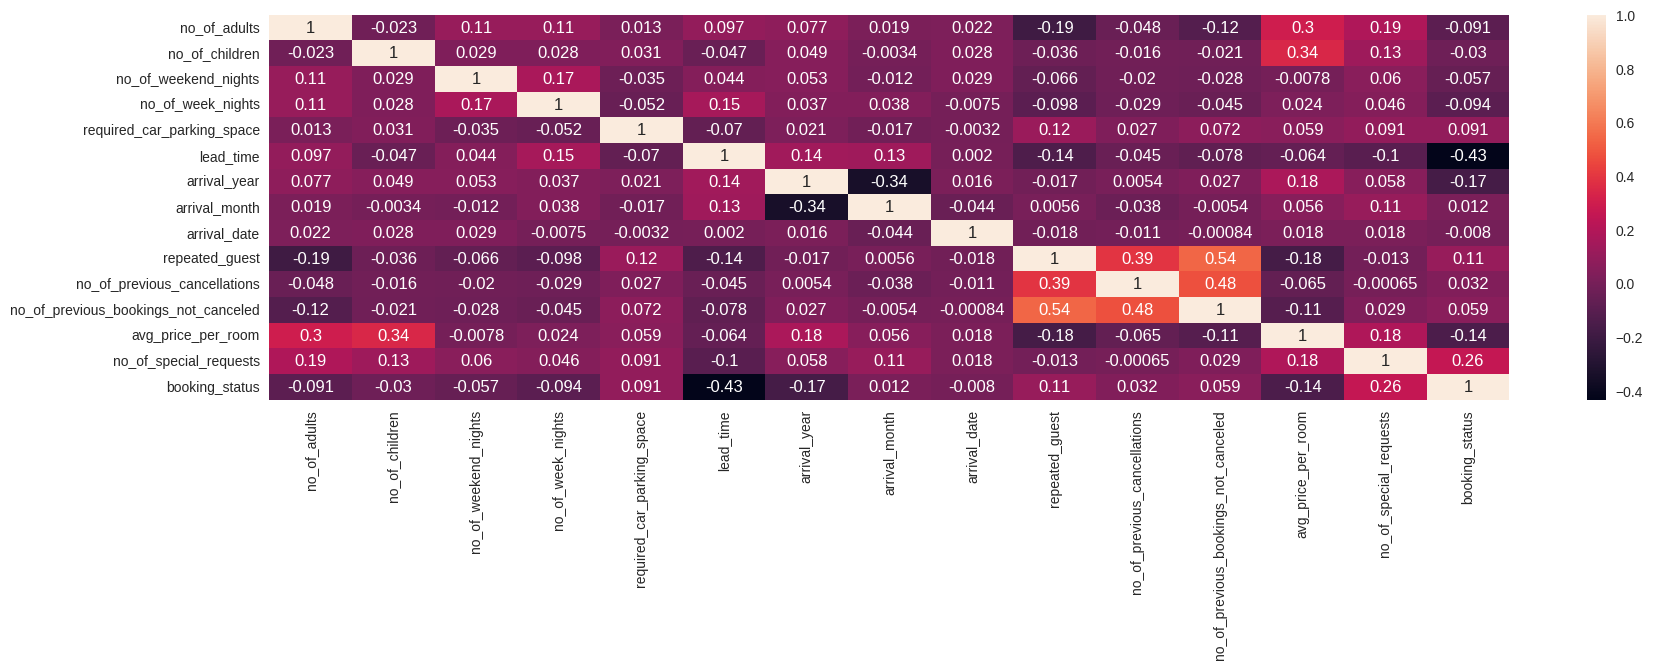

In [31]:
# plot pearson
pearson_num = pd.concat([X_train_num, y_train_map],axis=1)
plt.figure(figsize=(20,5))
sns.heatmap(pearson_num.corr(), annot=True)

In [32]:
# Assuming X_train and y_train are your feature and target matrices
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_num, y_train_map)

# Melihat nilai score hasil training untuk masing-masing fitur
feature_importance = pd.Series(model.feature_importances_, index=X_train_num.columns).sort_values(ascending=False)
feature_importance

lead_time                               0.335674
avg_price_per_room                      0.205355
arrival_date                            0.106395
arrival_month                           0.092331
no_of_special_requests                  0.088955
no_of_week_nights                       0.055562
no_of_weekend_nights                    0.037288
arrival_year                            0.027867
no_of_adults                            0.027863
no_of_children                          0.009916
required_car_parking_space              0.006044
repeated_guest                          0.003450
no_of_previous_bookings_not_canceled    0.002925
no_of_previous_cancellations            0.000375
dtype: float64

<Axes: >

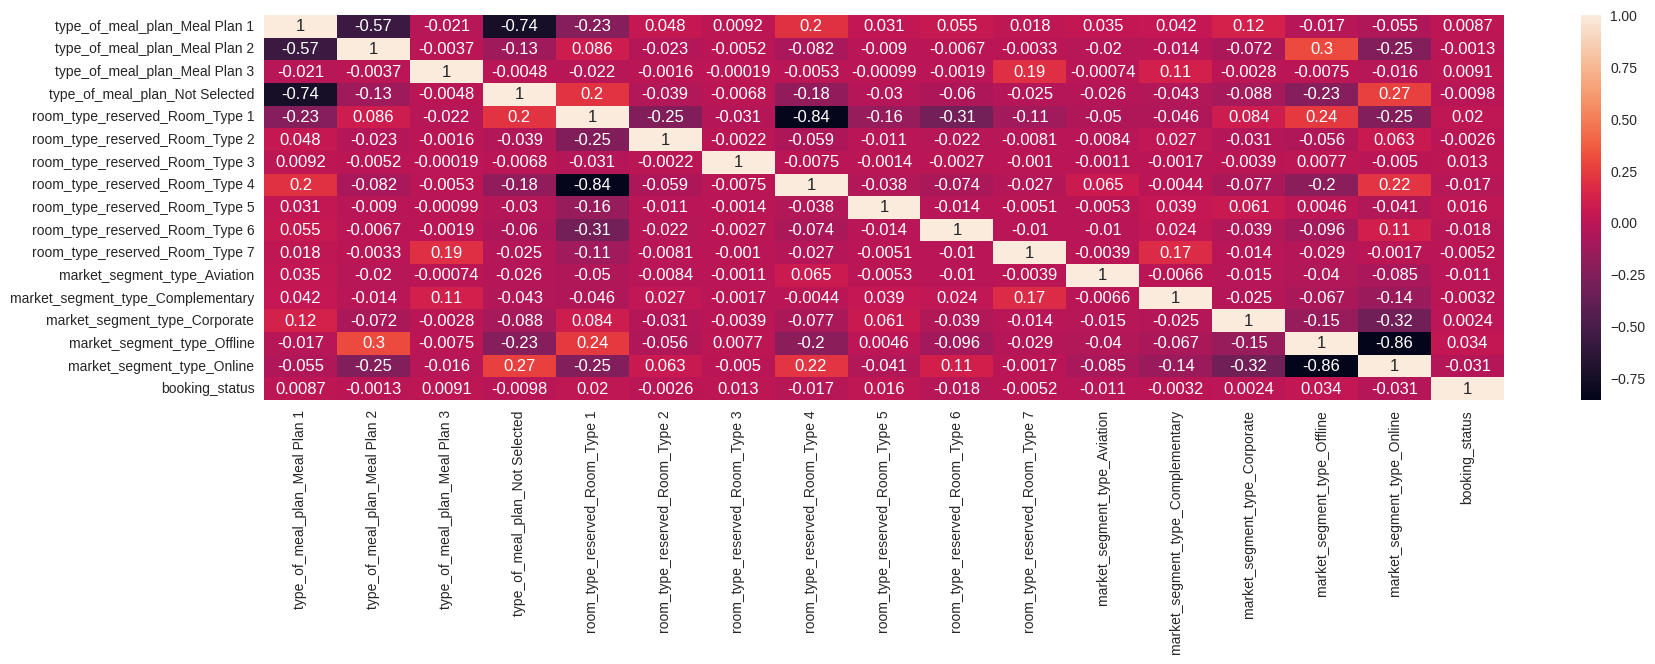

In [33]:
# plot pearson
pearson_cat = pd.concat([X_test_cat_ohe_df, y_train_map],axis=1)
plt.figure(figsize=(20,5))
sns.heatmap(pearson_cat.corr(), annot=True)

Insight : From the results of feature importance and Pearson correlation from numerical and categorical data, only the numerical columns 'lead_time' , 'avg_price_per_room' , 'no_of_special_requests', 'repeated_guest' have high values. Meanwhile the 'arrival_date' and 'arrival_date' columns are categorical columns, so they are not very useful for predictions on new data and also all categorical features will not be used.

In [34]:
# final kolom
columns_final = ['lead_time' , 'avg_price_per_room' , 'no_of_special_requests', 'repeated_guest']

In [35]:
# final dataframe
X_train_final = X_train.loc[:,columns_final]
X_test_final = X_test.loc[:,columns_final]
X_test_final.head(2)

,lead_time,avg_price_per_room,no_of_special_requests,repeated_guest
4968,3,90.00,3,0
34540,9,48.67,0,0


# Model Definition

In [36]:
# model definition
svc = SVC()
dt = DecisionTreeClassifier()
rf  = RandomForestClassifier()
knn = KNeighborsClassifier()
xb = xgb.XGBClassifier()

models_list = [svc,dt,rf,knn,xb]

In [37]:
for model in models_list:
    model.fit(X_train_final, y_train_map)

# Model Training

**Training SVM Model**

In [38]:
# Model definition for svm algorithm using pipeline
pipe_svm = Pipeline([("SVMscaler", MinMaxScaler()), ("svm", SVC())])
pipe_svm.fit(X_train_final,y_train_map)

Pipeline(steps=[('SVMscaler', MinMaxScaler()), ('svm', SVC())])

In [39]:
# Find the value of cross validation svm
kf=KFold(n_splits=5)
scoressvm = cross_val_score(pipe_svm, X_train_final,y_train_map, cv=kf)
print("--Support Vector Machine--")
print("Cross Validation array           :",scoressvm)
print("Best Cross Validation score      :",scoressvm.mean())
print("Standar Deviasi Cross Validation :",scoressvm.std())

--Support Vector Machine--
Cross Validation array           : [0.79014473 0.7875603  0.79203997 0.78566506 0.78790489]
Best Cross Validation score      : 0.7886629910406615
Standar Deviasi Cross Validation : 0.0022080660707926745


**Training Decision Tre Model**

In [40]:
# Model definition for decision tree algorithm using pipeline
pipe_dt = Pipeline([("DTscaler",MinMaxScaler()), ("DTC",DecisionTreeClassifier(random_state=10))])
pipe_dt.fit(X_train_final,y_train_map)

Pipeline(steps=[('DTscaler', MinMaxScaler()),
                ('DTC', DecisionTreeClassifier(random_state=10))])

In [41]:
# Finding the value of the cross validation decision tree
kf=KFold(n_splits=5)
scoresDT = cross_val_score(pipe_dt, X_train_final,y_train_map, cv=kf)
print("--Decision Tree--")
print("Cross Validation array           :",scoresDT)
print("Best Cross Validation score      :",scoresDT.mean())
print("Standar Deviasi Cross Validation :",scoresDT.std())

--Decision Tree--
Cross Validation array           : [0.832357   0.83304618 0.82770503 0.81822881 0.8252929 ]
Best Cross Validation score      : 0.8273259820813232
Standar Deviasi Cross Validation : 0.005386415815985831


Training Random Forest Model

In [42]:
# Model definition for random forest algorithm
pipe_RF = Pipeline([("RFscaler",MinMaxScaler()), ("RFC",RandomForestClassifier(random_state=10))])
pipe_RF.fit(X_train_final,y_train_map)

Pipeline(steps=[('RFscaler', MinMaxScaler()),
                ('RFC', RandomForestClassifier(random_state=10))])

In [43]:
# Finding the value of cross validation random forest
kf=KFold(n_splits=5)
scoresRF = cross_val_score(pipe_RF,X_train_final,y_train_map, cv=kf)
print("--Random Forest--")
print("Cross Validation array           :",scoresRF)
print("Best Cross Validation score      :",scoresRF.mean())
print("Standar Deviasi Cross Validation :",scoresRF.std())

--Random Forest--
Cross Validation array           : [0.85458305 0.85027567 0.84855272 0.84838043 0.84510682]
Best Cross Validation score      : 0.8493797381116472
Standar Deviasi Cross Validation : 0.003092490716221152


**Training KNN**

In [44]:
# Model definition for KNN algorithm
pipe_KNN = Pipeline([("KNNscaler",MinMaxScaler()), ("KNN",KNeighborsClassifier())])
pipe_KNN.fit(X_train_final,y_train_map)

Pipeline(steps=[('KNNscaler', MinMaxScaler()), ('KNN', KNeighborsClassifier())])

In [45]:
# Finding the KNN cross validation value
kf=KFold(n_splits=5)
scoresKNN = cross_val_score(pipe_KNN, X_train_final,y_train_map, cv=kf)
print("--K-Nearest Neighbor--")
print("Cross Validation array           :",scoresKNN)
print("Best Cross Validation score      :",scoresKNN.mean())
print("Standar Deviasi Cross Validation :",scoresKNN.std())

--K-Nearest Neighbor--
Cross Validation array           : [0.84097174 0.83649207 0.83132323 0.83597519 0.83373535]
Best Cross Validation score      : 0.8356995175740867
Standar Deviasi Cross Validation : 0.003209684637407326


**Training XGBoost**

In [46]:
pipe_XGB = Pipeline([("scaler", MinMaxScaler()), ("XGB", xgb.XGBClassifier())])
pipe_XGB.fit(X_train_final,y_train_map)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [47]:
# Finding the XGB cross validation value
kf=KFold(n_splits=5)
scoresXGB = cross_val_score(pipe_XGB, X_train_final,y_train_map, cv=kf)
print("--K-Nearest Neighbor--")
print("Cross Validation array           :",scoresXGB)
print("Best Cross Validation score      :",scoresXGB.mean())
print("Standar Deviasi Cross Validation :",scoresXGB.std())

--K-Nearest Neighbor--
Cross Validation array           : [0.84855272 0.85217092 0.84390076 0.84717436 0.84751895]
Best Cross Validation score      : 0.8478635423845624
Standar Deviasi Cross Validation : 0.0026580373226294846


#  Model Evaluation

**Evaluation SVM model**

In [48]:
kf = KFold(n_splits=5)
predicted_svm = cross_val_predict(pipe_svm, X_train_final, y_train_map, cv=kf)
predicted_svm_test = pipe_svm.predict(X_test_final)

# Generate the classification report
class_report_svm = classification_report(y_train_map, predicted_svm)
class_report_svm_test = classification_report(y_test_map, predicted_svm_test)

print("-- Support Vector Machine Classification Report --")
print(class_report_svm)

print("-- Support Vector Machine Test Classification Report --")
print(class_report_svm_test)

-- Support Vector Machine Classification Report --
              precision    recall  f1-score   support

           0       0.77      0.50      0.61      9469
           1       0.79      0.93      0.86     19551

    accuracy                           0.79     29020
   macro avg       0.78      0.71      0.73     29020
weighted avg       0.79      0.79      0.77     29020

-- Support Vector Machine Test Classification Report --
              precision    recall  f1-score   support

           0       0.79      0.51      0.62      2416
           1       0.79      0.93      0.86      4839

    accuracy                           0.79      7255
   macro avg       0.79      0.72      0.74      7255
weighted avg       0.79      0.79      0.78      7255



**Evaluation Decision tree model**

In [49]:
kf = KFold(n_splits=5)
predicted_dt = cross_val_predict(pipe_dt, X_train_final, y_train_map, cv=kf)
predicted_dt_test = pipe_dt.predict(X_test_final)

# Generate the classification report
class_report_dt = classification_report(y_train_map, predicted_dt)
class_report_dt_test = classification_report(y_test_map, predicted_dt_test)

print("-- Decision Tree Classification Report --")
print(class_report_dt)

print("-- Decision Tree Test Classification Report --")
print(class_report_dt_test)

-- Decision Tree Classification Report --
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      9469
           1       0.88      0.87      0.87     19551

    accuracy                           0.83     29020
   macro avg       0.80      0.81      0.80     29020
weighted avg       0.83      0.83      0.83     29020

-- Decision Tree Test Classification Report --
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      2416
           1       0.88      0.87      0.88      4839

    accuracy                           0.84      7255
   macro avg       0.81      0.82      0.82      7255
weighted avg       0.84      0.84      0.84      7255



**Evaluation Random forest model**

In [50]:
kf = KFold(n_splits=5)
predicted_RF = cross_val_predict(pipe_RF, X_train_final, y_train_map, cv=kf)
predicted_RF_test = pipe_RF.predict(X_test_final)

# Generate the classification report
class_report_RF = classification_report(y_train_map, predicted_RF)
class_report_RF_test = classification_report(y_test_map, predicted_RF_test)

print("-- Random Forest Classification Report --")
print(class_report_RF)
print("-- Random Forest Test Classification Report --")
print(class_report_RF_test)

-- Random Forest Classification Report --
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      9469
           1       0.88      0.90      0.89     19551

    accuracy                           0.85     29020
   macro avg       0.83      0.82      0.83     29020
weighted avg       0.85      0.85      0.85     29020

-- Random Forest Test Classification Report --
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      2416
           1       0.88      0.91      0.89      4839

    accuracy                           0.86      7255
   macro avg       0.84      0.83      0.83      7255
weighted avg       0.85      0.86      0.85      7255



**Evaluation KNN model**

In [51]:
kf = KFold(n_splits=5)
predicted_KNN = cross_val_predict(pipe_KNN, X_train_final, y_train_map, cv=kf)
predicted_KNN_test = pipe_KNN.predict(X_test_final)

# Generate the classification report
class_report_KNN = classification_report(y_train_map, predicted_KNN)
class_report_KNN_test = classification_report(y_test_map, predicted_KNN_test)

print("-- KNN Classification Report --")
print(class_report_KNN)

print("-- KNN Test Classification Report --")
print(class_report_KNN_test)

-- KNN Classification Report --
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      9469
           1       0.86      0.91      0.88     19551

    accuracy                           0.84     29020
   macro avg       0.82      0.80      0.81     29020
weighted avg       0.83      0.84      0.83     29020

-- KNN Test Classification Report --
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      2416
           1       0.85      0.91      0.88      4839

    accuracy                           0.84      7255
   macro avg       0.82      0.80      0.81      7255
weighted avg       0.83      0.84      0.83      7255



**Evaluation XGBoost model**

In [52]:
kf = KFold(n_splits=5)
predicted_XGB = cross_val_predict(pipe_XGB, X_train_final, y_train_map, cv=kf)
predicted_XGB_test = pipe_XGB.predict(X_test_final)

# Generate the classification report
class_report_XGB = classification_report(y_train_map, predicted_XGB)
class_report_XGB_test = classification_report(y_test_map, predicted_XGB_test)

print("-- XGBoost Classification Report --")
print(class_report_XGB)
print("-- XGBoost Test Classification Report --")
print(class_report_XGB_test)

-- XGBoost Classification Report --
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      9469
           1       0.86      0.93      0.89     19551

    accuracy                           0.85     29020
   macro avg       0.84      0.80      0.82     29020
weighted avg       0.85      0.85      0.84     29020

-- XGBoost Test Classification Report --
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      2416
           1       0.86      0.93      0.89      4839

    accuracy                           0.85      7255
   macro avg       0.85      0.81      0.83      7255
weighted avg       0.85      0.85      0.85      7255



**Model Evaluation Cross Validation**

In [53]:
# model list
pipe_list = [pipe_dt,pipe_RF,pipe_KNN,pipe_XGB,pipe_svm]

# Print the mean and standard deviation of the model scores
for i in pipe_list:
    cross_score = cross_val_score(i, X_train_final, y_train_map, cv=5)

    print(i,'   Accuracy for each fold  =    ', cross_score)
    print('   CV Scores: Mean         =    ', cross_score.mean())
    print('   CV Scores: Std          =    ', cross_score.std())

Pipeline(steps=[('DTscaler', MinMaxScaler()),
                ('DTC', DecisionTreeClassifier(random_state=10))])    Accuracy for each fold  =     [0.83407994 0.83304618 0.82787733 0.81874569 0.82477602]
   CV Scores: Mean         =     0.8277050310130944
   CV Scores: Std          =     0.0056222042286734756

Pipeline(steps=[('RFscaler', MinMaxScaler()),
                ('RFC', RandomForestClassifier(random_state=10))])    Accuracy for each fold  =     [0.85475534 0.84975879 0.84906961 0.84493453 0.84510682]
   CV Scores: Mean         =     0.8487250172294969
   CV Scores: Std          =     0.003605866563827763

Pipeline(steps=[('KNNscaler', MinMaxScaler()), ('KNN', KNeighborsClassifier())])    Accuracy for each fold  =     [0.8423501  0.83718125 0.8321847  0.83459683 0.8321847 ]
   CV Scores: Mean         =     0.8356995175740869
   CV Scores: Std          =     0.0038039358014419133

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('XGB',
                 XGBClassifier(b

**Insight** :
1. RandomForest = 0.848
2. DecissionTree = 0.827
3. XGBoost = 0.846
4. KNNeighbor = 0.835
5. SVM = 0.788

**Based on all the evaluations carried out on the baseline model, the Random Forest model has the best precision and performance.Next, we use Random Forest to do hyperparameter tuning**

**Hyperparameter Tuning Random Forest**

In [54]:
param_grid_RF = {'RFC__n_estimators': [300,400,500],
              'RFC__max_depth': [None, 'verbose'],
              'RFC__max_features' : ['sqrt', 'log2'],
              'RFC__min_samples_split': [2,5,10],
              'RFC__min_samples_leaf': [1,2]
              }
grid = GridSearchCV(pipe_RF, param_grid_RF, cv=5)
grid.fit(X_train_final, y_train_map)

# Print the best parameters and the best score
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best parameters:  {'RFC__max_depth': None, 'RFC__max_features': 'sqrt', 'RFC__min_samples_leaf': 1, 'RFC__min_samples_split': 10, 'RFC__n_estimators': 400}
Best score:  0.8569262577532737


**Tuned Model Random Forest**

In [63]:
# new models
RF_tuned = RandomForestClassifier(n_estimators=400, max_depth=None, max_features='sqrt', min_samples_leaf =1 , min_samples_split=10)

# model training and fitting
RF_tuned.fit(X_train_final, y_train_map)

RandomForestClassifier(min_samples_split=10, n_estimators=400)

In [64]:
# classification report for tuned model
y_pred_new = RF_tuned.predict(X_test_final)

print(RF_tuned)
print(classification_report(y_test_map, y_pred_new), end='')

RandomForestClassifier(min_samples_split=10, n_estimators=400)
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      2416
           1       0.87      0.93      0.90      4839

    accuracy                           0.86      7255
   macro avg       0.85      0.83      0.84      7255
weighted avg       0.86      0.86      0.86      7255


Insight : The precision value of the tuned model increases, even though the accuracy tends to be the same.

# Model Saving

In [66]:
# Save best model
dump(RF_tuned, 'RF_pipe.joblib')

with open('list_num_cols.txt', 'w') as file_2:
  json.dump(columns_final, file_2)

# Conclusion

A. EDA Conclusion
  1. In the 2017-2018 period, around 67% of customers canceled hotel reservations.
  2. The majority of individuals who cancel their reservations are those who made hotel bookings through online channels.
  3. The period from August to December sees a significant surge in customer demand for hotel bookings.
  4. Long interval between hotel booking and the scheduled check-in time correlates with a reduced probability of reservation cancellation.

B. Model Conclusion
- The model is designed for forecasting customer cancellations, placing particular importance on precision and overall performance. In this scenario, the Random Forest stands out. Both the default model and the GridSearch model exhibit commendable performance. Nevertheless, opting for the GridSearch model is recommended due to its superior attributes, as indicated by a notable improvement in precision value, comprehensive cross-validation assessments, and detailed classification reports.

C. Recommendation
- Based on EDA, a significant portion of cancellations come from customers who booked online, consider optimizing the online booking process. This could provide clearer information, or implement features such as non-refundable booking options with added benefits.

- The high demand for hotel bookings was observed from August to December. Launch targeted promotions, special packages, or discounts to attract and retain customers.

- Since a longer interval between booking and check-in is associated with a reduced probability of cancellation. This can be reduced through early bird discounts, exclusive offers, or other perks for reservations made well in advance.

D. Further Improvement
- Continue fine-tuning hyperparameters, consider explore more parameters like max_depth, min_samples_leaf, and max_features.
- Explore other supervised algorithms that may perform well. Sometimes, different models can capture patterns that a Random Forest might miss.